In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize, least_squares
import time
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Question 1: Ridge regression

\begin{align}
\hat{\beta} = \text{argmin}_\beta \quad f(\beta;X,y,\tau)
\end{align}
where $f(\beta;X,y,\tau)=|| X \beta - y||_F^2 + \tau ||\beta||_2^2$. The minimum can be taken by setting the derivative of f with respect to $\beta$ to 0.
\begin{align}
0 = \partial_\beta f &= 2 X^TX \beta - 2X^Ty + 2\tau\beta\\
\Rightarrow& (X^TX + \tau \mathbb{1})\beta = X^Ty\\
\Rightarrow& \hat{\beta} = S_\tau^{-1} X^Ty\\
\Rightarrow& \hat{\beta} = S_\tau^{-1} X^T (X \beta^* + \epsilon)\\
\Rightarrow& \hat{\beta} = S_\tau^{-1} S \beta^* + S_\tau^{-1} X^T\epsilon
\end{align}
Now we can calculate the expected value
\begin{align}
    \mathbb{E}[\hat{\beta}] &= \mathbb{E}[S_\tau^{-1} S \beta^*] + \mathbb{E}[S_\tau^{-1} X^T\epsilon]\\
    &= S_\tau^{-1} S \beta^* \quad \text{since }\mathbb{E}[\epsilon] = 0
\end{align}

For the variance, we get
\begin{align}
\text{Var}[\hat{\beta}] &= \text{Var}[S_\tau^{-1} X^T (X \beta^* + \epsilon)]\\
&= (S_\tau^{-1} X^T) \text{Var}[X \beta^* + \epsilon] (S_\tau^{-1} X^T)^T\\
&= (S_\tau^{-1} X^T) (\text{Var}[X \beta^*] + \text{Var}[\epsilon] + 2 \text{Cov}[X \beta^*, \epsilon]) (S_\tau^{-1} X^T)^T\\
&= (S_\tau^{-1} X^T) (0 + \sigma^2 + 0) (S_\tau^{-1} X^T)^T \quad \text{since }X \beta^*\text{ is certain and not correlated to }\epsilon\\
&= \sigma^2 S_\tau^{-1} X^T X S_\tau^{-1, T}\\
&= \sigma^2 S_\tau^{-1} S S_\tau^{-1,T}
\end{align}

$S$ is symmetric, because $S^T = (X^T X)^T = X^T X = S$. $S_\tau^{-1}$ is symmetric as well, because $\tau \mathbb{1}$ is also symmetric. Therefore, we get
\begin{align}
\text{Var}[\hat{\beta}] &= \sigma^2 S_\tau^{-1} S S_\tau^{-1}\\
&=\sigma^2 S_\tau^{-1} S_\tau^{-1} S\\
&=\sigma^2 S_\tau^{-2} S\\
\end{align}

# Question 2: Denoising of a CT image

In [2]:
### mostly the same as in exercise 5
def construct_X(M, alphas, Np=None, tau=0):
    # calculating Np if not given
    if Np == None:
        Np_estimate = int(np.floor(np.sqrt(2)*M))
        Np = Np_estimate if Np_estimate % 2 == 1 else Np_estimate + 1
        print('Use Np={:d}'.format(Np))
        
    # defining the dimensions
    D = M*M
    N = Np * len(alphas)
    # creating the normal vectors
    n = np.array([[np.cos(alpha*np.pi/180), -np.sin(alpha*np.pi/180)] for alpha in alphas])
    # coordinates of detector rotation center
    # M - 1, because indexing starting from 0
    s0 = np.array([(M-1)/2, (M-1)/2])
    
    beta_flat_index = np.arange(D) # just an array with all indices of beta
    
    # C contains the vector from center of rotation to beta element
    C = np.empty((2, D)) # create C
    C[0,:] = -s0[0] + np.mod(beta_flat_index, M) # x-value: x(beta) = modulo
    C[1,:] = -s0[1] + np.floor_divide(beta_flat_index, M) #y-value: y(beta) = floor_division
    
    
    # np.tensordot gives the projected length of C vectors on
    # Since they are measured from the rotation center, 0 corresponds to the rotation center (located at a length of Np/2)
    p = (Np-1)/2 - np.tensordot(n, C, axes=((1), (0)))
    # TODO: what to do with values smaller than 0?
    
    # calculate weights and indices
    # detector_index_1 is the integral part of p, i.e. the first (most left) sensor the beta element is contributing to
    # beta is contributing to detector_index_1 with weight_1 = 1 - weight_2, where weight_2 is the fraction inside the most neighbouring sensor element
    # therefore weight_2 is the fractional part of p
    # the neighbouring element of detector_index_2 is the one right of it, so just + 1
    weight_2, detector_index_1 = np.modf(p)
    weight_1 = 1 - weight_2
    detector_index_2 = detector_index_1 + 1
    
    # now it can happen, that some are out of bounds. Here we just replace these values with weight 0
    # TODO: performance?
    mask_detector_index_1 = np.logical_or(detector_index_1 < 0, detector_index_1 >= Np)
    weight_1[mask_detector_index_1] = 0
    detector_index_1[mask_detector_index_1] = 0 # just to avoid later errors
    mask_detector_index_2 = np.logical_or(detector_index_2 < 0, detector_index_2 >= Np)
    weight_2[mask_detector_index_2] = 0
    detector_index_2[mask_detector_index_2] = 0 # just to avoid later index errors
    
    
    # merge arrays
    weights = np.array([])
    weights = np.append(weights, [weight_1[angle_index] for angle_index in range(len(alphas))])
    weights = np.append(weights, [weight_2[angle_index] for angle_index in range(len(alphas))])
    # this is what is called i_indices
    detector_indices = np.array([])
    detector_indices = np.append(detector_indices, [Np*angle_index + detector_index_1[angle_index] for angle_index in range(len(alphas))])
    detector_indices = np.append(detector_indices, [Np*angle_index + detector_index_2[angle_index] for angle_index in range(len(alphas))])
    
    # create j indices
    beta_indices = np.array([])
    # we have to flip the beta_flat_index array, because otherwise the picture is upside down
    beta_indices = np.append(beta_indices, [beta_flat_index[::-1] for _ in range(len(alphas))])
    beta_indices = np.append(beta_indices, [beta_flat_index[::-1] for _ in range(len(alphas))])
    
    if tau != 0:
        # append to sparse matrix sqrt(Tau)*1
        # ... create diagonal elements with value sqrt(tau)
        weights = np.append(weights, [np.sqrt(tau) for _ in range(D)])
        # ... first index: have to start from N, because sqrt(Tau)*1 is appended
        detector_indices = np.append(detector_indices, np.arange(N, N+D))
        # ... second index: just start from 0 to D
        beta_indices = np.append(beta_indices, np.arange(D))
        # modify N to not modify sp.coo_matrix call
        N += D
    
    # i hope duplicate entries will sum
    X = sp.coo_matrix((weights, (detector_indices, beta_indices)), shape=(N, D), dtype = numpy.float32)
    return X

In [3]:
def get_beta(M, Np, alphas, y, tau=0, error=1e-5):
    t0 = time.time()
    x = construct_X(M, alphas, Np, tau)
    t1 = time.time()
    print('Constructed X in {:f}s'.format(t1 - t0))
    print('Sparsity:', x.nnz/(x.get_shape()[0]*x.get_shape()[1]))
    t0 = time.time()
    if tau != 0:
        y = np.append(y, [0 for _ in range(M*M)])
    beta = lsqr(x, y, atol=error, btol=error)[0]
    t1 = time.time()
    print('Solved for beta in {:f}s'.format(t1 - t0))
    return beta

In [4]:
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')

Constructed X in 0.378474s
Sparsity: 0.007272727272727273
Solved for beta in 1.320373s
Constructed X in 0.470778s
Sparsity: 0.0022191655204034846
Solved for beta in 2.647175s
Constructed X in 0.458277s
Sparsity: 0.0022191655204034846
Solved for beta in 1.369626s
Constructed X in 0.450709s
Sparsity: 0.0022191655204034846
Solved for beta in 0.793385s
Constructed X in 0.450333s
Sparsity: 0.0022191655204034846
Solved for beta in 0.369708s
Constructed X in 0.425737s
Sparsity: 0.0022191655204034846
Solved for beta in 0.230858s


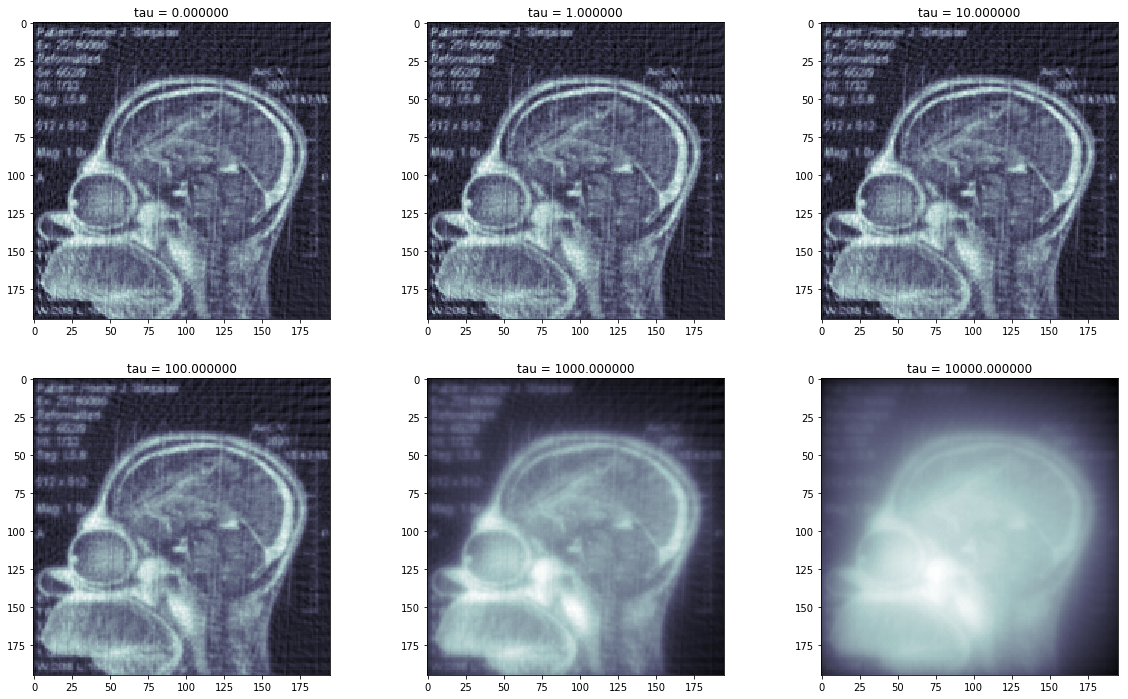

In [5]:
sorted_alphas = np.argsort(alphas_195)

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for k, tau in enumerate([0, 1, 10, 100, 1000, 10000]):
    j = 3 # roughly 64 angles
    y_reduced = np.array([])
    y_reduced = np.append(y_reduced, [y_195[i*275:(i+1)*275] for i in range(0, len(alphas_195), j)])
    beta = get_beta(195, 275, alphas_195[sorted_alphas][::j], y_reduced, tau=tau, error=1e-4)
    ax[k//3, k %3].imshow(beta.reshape(195, 195), cmap='bone')
    ax[k//3, k %3].set_title('tau = {:f}'.format(tau), fontsize='12')
plt.show()

For me the pictures blur out and brightness is transported to already bright regions resulting in a shining of the image.

Constructed X in 0.946661s
Sparsity: 0.007272727272727273
Solved for beta in 4.636954s


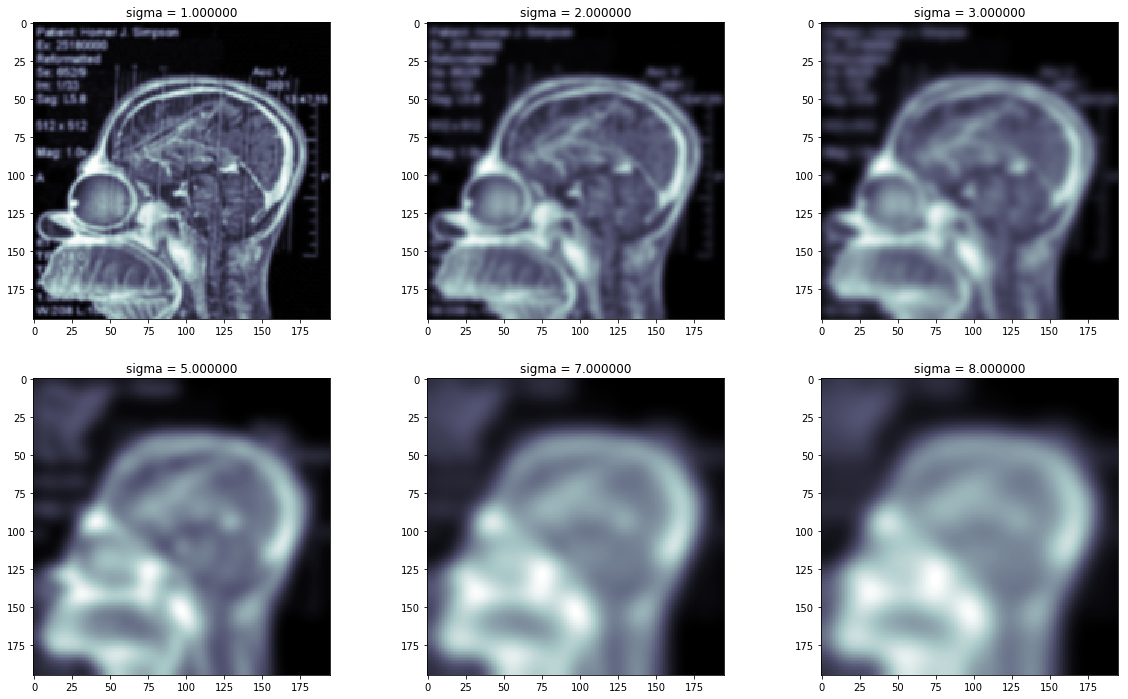

In [6]:
beta = get_beta(195, 275, alphas_195, y_195, tau=0, error=1e-4)

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for k, sigma in enumerate([1, 2, 3, 5, 7, 8]):
    ax[k//3, k %3].imshow(gaussian_filter(beta.reshape(195, 195), sigma), cmap='bone')
    ax[k//3, k %3].set_title('sigma = {:f}'.format(sigma), fontsize='12')
plt.show()

This filter just blur out.

# Question 3: Automatic feature selection for regression

In [7]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
# use only 1 and 7 for this exercise
mask_all = np.logical_or(target == 1, target == 7)
X_all = data[mask_all]
X_all /= np.max(data)
y_all = target[mask_all]
y_all[y_all == 7] = -1

In [8]:
def frob_squared(beta, args):
    # add a star before args if using least_squares. Scipy is inconsistent here.
    # args = (X_t, y)
    return np.sum((np.dot(args[0], beta) - args[1]) ** 2)
def omp_regression(X, y, T):
    N = X.shape[0]
    D = X.shape[1]
    
    A = set([])
    B = set(np.arange(D))
    r = y
    
    beta = np.empty((D, T))
    beta[:, -1] = np.zeros((D)) # for optimization only, will be overwritten
    
    X_t = np.zeros(X.shape, dtype=X.dtype)
    
    for t in range(T):
        # calculate correlation
        corr = np.abs(np.dot(X.transpose(), r))
        
        j_choices = np.argsort(corr) # ascending order...
        not_used = np.array([j not in A for j in j_choices])
        j_best = j_choices[not_used][-1] # ...therefore use the last one
        
        # add to A and remove from B
        A.add(j_best)
        B.remove(j_best)
        
        # update X_t
        X_t[:, j_best] = X[:, j_best]
        
        # optimization
        # least squares is stable, but super slow.
        # minimize throws some errors, but should be okay. If you have problems, uncomment the following if clause
        # or use least_squares
        # beta_hat = least_squares(frob_squared, beta[:,t - 1], args=[X_t, y], xtol = 1e-4, gtol = 1e-4, ftol = 1e-4) 
        beta_hat = minimize(frob_squared, beta[:,t - 1], args=[X_t, y])
        
        # check if somehow failed
        # if not beta_hat["success"]:
        #    raise ValueError('Minimizing failed. Original: {:s}'.format(beta_hat["message"]))
        # save beta
        beta[:,t] = beta_hat["x"]
        # update residue
        r = y - np.dot(X_t, beta_hat["x"])
    
    return beta

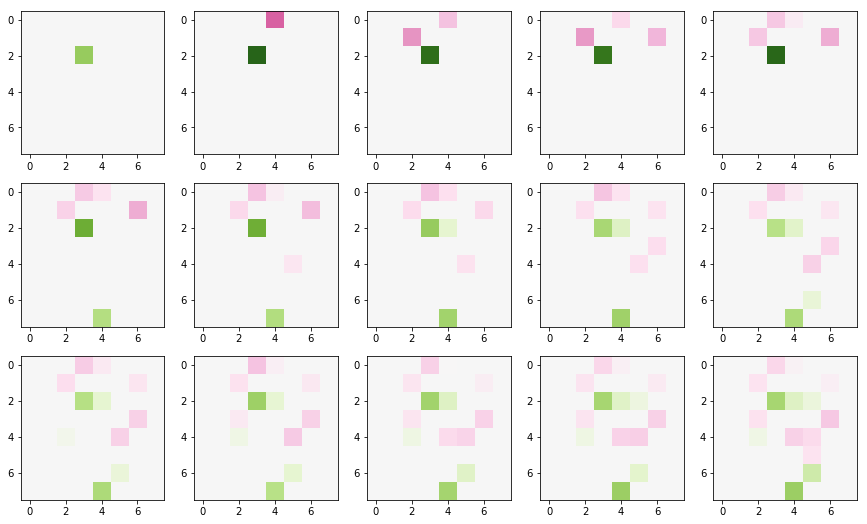

In [11]:
T = 15

beta_hat = omp_regression(X_all, y_all, T)

plot_cols = 5

plot_rows = int(np.ceil(T / plot_cols))
fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(3*plot_cols, plot_rows*3))
for i in range(plot_cols*plot_rows):
    if i >= T:
        ax[i//plot_cols][i%plot_cols].axis('off')
    else:
        ax[i//plot_cols][i%plot_cols].imshow(beta_hat[:,i].reshape(8, 8), cmap='PiYG', vmin=-np.max(np.abs(beta_hat)), vmax=np.max(np.abs(beta_hat)))
plt.show()



In the plot green indicates positive values and pink negative ones. A good distinction between both is to check if the value in $\beta$ is larger or smaller than 0.

As you can see in the plot (t = 7), the most important pixels for digit 1 are (2,3), (7,4) and (2,4). The most important digits for digit 7 are (1,2), (0,4) and (1,6).
In exercise 2 I chosed the pixels upon the difference of the average images for all 1s and 7s in the dataset. There I chosed for digit 1 (2,3), (2,4) and (7,4) and for digit 7 (1,2), (0,5) and (1,6).
For digit 1 this matches exactly the results for $\beta$. For digit 7, they do not, but you can see in the plot, that they appear later und that the noise is much higher for digit 7.

## One against the rest classification

In [12]:
def create_aux_labels(target_names, target):
    y = {}
    for j in target_names:
        aux_labels = np.ones(target.shape)
        aux_labels[target != j] = -1
        y[j] = aux_labels
    return y

def progress(percent, prefix, length = 50):
    sharps = int(percent * length/100)
    print(prefix, '[{:s}{:s}] {:.1f}%'.format(sharps*'#', (length-sharps)*' ', percent), end='\r')
    if percent == 100:
        print('\n')

# create a kfold instance
kf = KFold(n_splits=10, shuffle=True)

X = data/np.max(data)
y = target
# from here on we assume, that the values of target are only the indices for target_names, but not the targets itself
aux_labels = create_aux_labels(target_names, y)

In [13]:
def get_confusion_matrix(predicted, truth, possible_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]):
    conf = np.empty((len(possible_labels), len(possible_labels)))
    # first dimension is pred, second is truth
    for i, k in enumerate(possible_labels):
        items, counts = np.unique(predicted[truth == k], return_counts=True)
        count_array = np.zeros(len(possible_labels))
        for fd in items:
            count_array[fd] = counts[items == fd]
        conf[i] = count_array
    return conf/len(predicted)

Disclaimer: the following will take forever.

 [##################################################] 100.0%



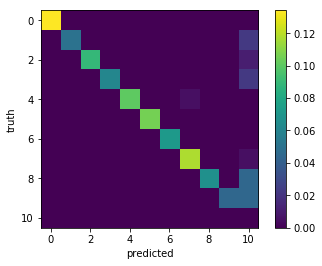

Mean error rate on 10 folds: 0.190854 (std: 0.038546)


In [14]:
T = 20
error_rates = []

total_workload = len(target_names)*kf.n_splits
counter = 0

progress(counter*100/total_workload, '')

for train, test in kf.split(X):

    pred = np.empty((len(target_names) + 1, len(test))) # +1 to get default
    pred[-1] = np.zeros(len(test))
    
    # run this without default category: just delete +1 and comment out pred[-1] = ...
    
    for k, aux_ts in aux_labels.items():
        
        classifier = omp_regression(X[train], aux_ts[train], T)[:,-1]
        pred[k] = np.dot(X[test], classifier)
        
        counter += 1
        progress(counter*100/total_workload, '')
        
    
    pred = np.argmax(pred, axis=0) # chooses automatically the default if all others below zero
    error_rates.append(np.count_nonzero(pred - y[test])/pred.shape[0])
    
    
    if counter == total_workload:
        conf = get_confusion_matrix(pred, y[test])
        fig, ax = plt.subplots(1, 1)
        cax = ax.imshow(conf)
        ax.set_xlabel('predicted')
        ax.set_ylabel('truth')
        plt.colorbar(cax)
        plt.show()
    
mean_error = np.mean(error_rates)
std_error = np.std(error_rates)

print('Mean error rate on 10 folds: {:f} (std: {:f})'.format(mean_error, std_error))

The problem of the classification is that a lot of instances are classified as unknown (default). The number of unknown samples decreases with T.
The default category enables a much smaller false positive classification, because the algorithm does not have to decide where it is uncertain. However, I get much better performance without the default category.